In [51]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error

from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, LSTM, Bidirectional, Activation, Dropout
from tensorflow.keras import regularizers, optimizers
from tensorflow.keras.callbacks import TensorBoard
# from kerastuner.tuners import RandomSearch


# Load Data

In [2]:
df_power = pd.read_csv("./data/power_usage_2016_to_2020.csv")
df_weather = pd.read_csv("./data/weather_2016_2020_daily.csv")

# Wrangle Data

In [3]:
def wrangle(df_power, df_weather):
    
    # Convert Dates to DateTime objects
    df_power["StartDate"] = pd.to_datetime(df_power.StartDate)
    df_weather["Date"] = pd.to_datetime(df_weather.Date)
    
    # Set Datetime columns to index
    df_power.index = df_power["StartDate"]
    df_weather.index = df_weather["Date"]
    
    # Drop unecessary columns
    drop_weather = ['Date']
    df_weather.drop(columns=drop_weather, inplace=True)
    
    drop_power = ["StartDate", "day_of_week"]
    df_power.drop(columns=drop_power, inplace=True)
    
    # Clean up column names
    rename_power = {"Value (kWh)": "kWh", "notes": "type_of_day"}
    df_power.rename(columns=rename_power, inplace=True)
    
    # Resample df_power to "D" (Day) granularity
    df_power = df_power.resample("D").sum()
    
    # Merge df_power, df_weather
    df = df_power.merge(df_weather, left_index=True, right_index=True)
    
    return df

In [4]:
df = wrangle(df_power, df_weather)
df.head()

,kWh,Day,Temp_max,Temp_avg,Temp_min,Dew_max,Dew_avg,Dew_min,Hum_max,Hum_avg,Hum_min,Wind_max,Wind_avg,Wind_min,Press_max,Press_avg,Press_min,Precipit,day_of_week
2016-01-06,29.691,1,85,74.8,68,74,71.4,66,100,89.4,65,21,9.5,0,29.8,29.8,29.7,0.00,2
2016-01-07,43.177,1,94,84.9,76,76,74.0,72,94,71.6,51,13,5.7,0,29.9,29.9,29.8,0.00,3
2016-01-08,50.057,1,97,86.5,75,76,73.3,67,96,67.3,37,20,6.0,0,30.0,29.9,29.9,0.00,4
2016-01-09,47.363,1,96,86.2,78,75,73.3,70,88,67.1,46,13,6.3,0,29.8,29.8,29.7,0.01,5
2016-01-10,42.203,1,81,71.1,61,64,59.4,57,90,68.7,45,8,3.3,0,30.0,29.9,29.9,0.00,6


# EDA Visualizations

<function matplotlib.pyplot.xlabel(xlabel, fontdict=None, labelpad=None, *, loc=None, **kwargs)>

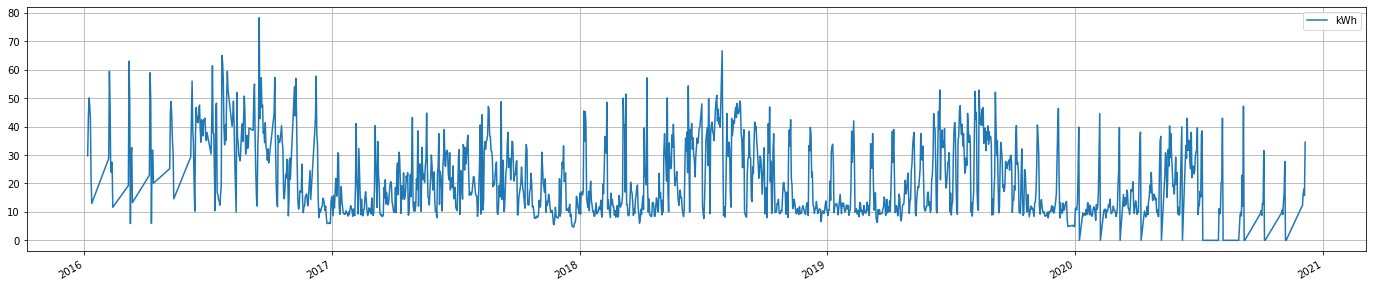

In [5]:
df.kWh.plot(figsize=(24,5), grid=True, legend=True)
plt.xlabel

<AxesSubplot:>

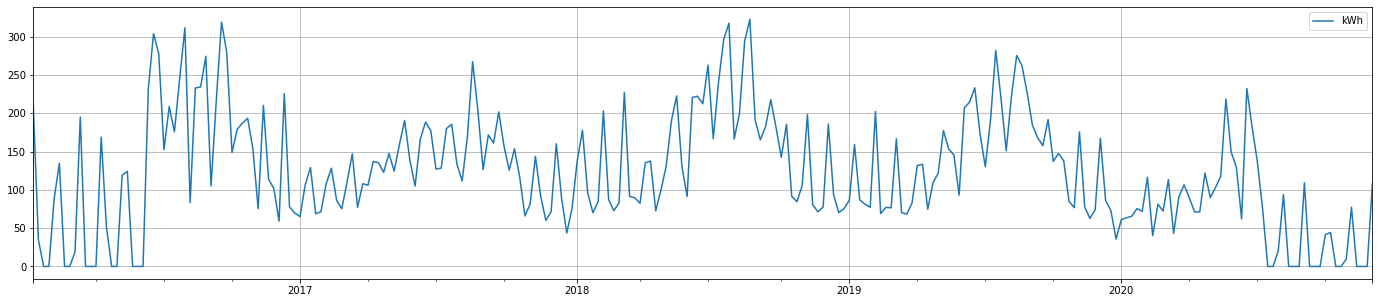

In [6]:
df["kWh"].resample("W").sum().plot(figsize=(24, 5), grid=True, legend=True)

<AxesSubplot:>

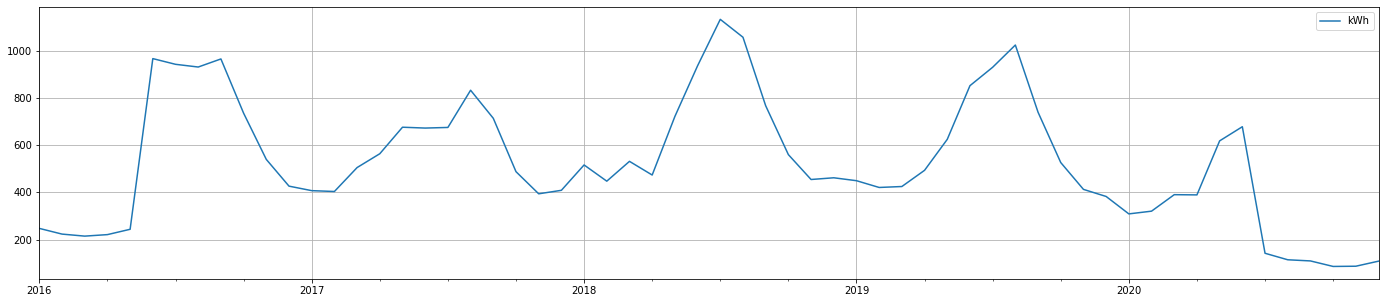

In [7]:
df["kWh"].resample("M").sum().plot(figsize=(24,5), grid=True, legend=True)

<AxesSubplot:>

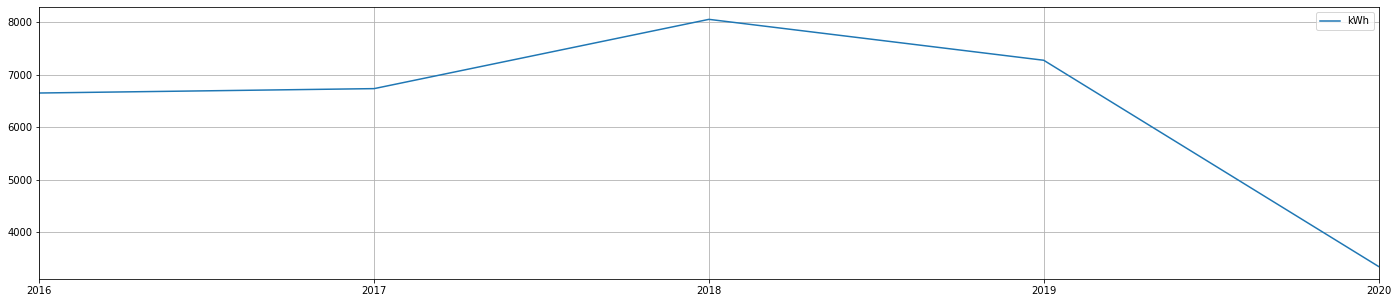

In [8]:
df["kWh"].resample("A").sum().plot(figsize=(24,5), grid=True, legend=True)

# Correlation Heat Map

<AxesSubplot:>

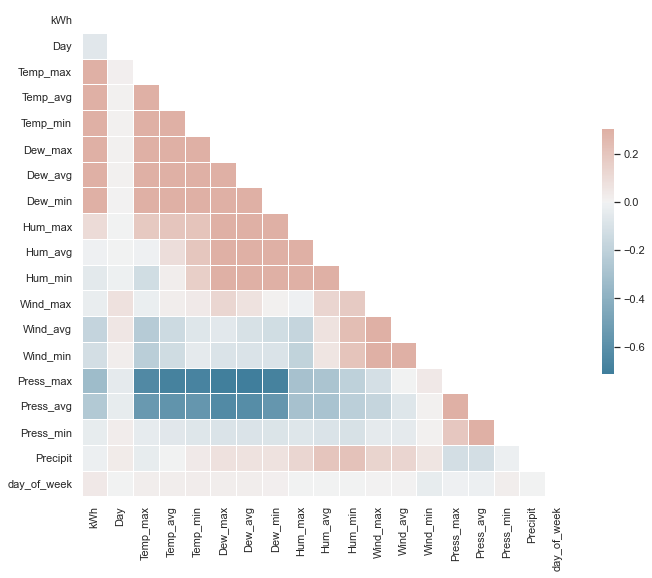

In [9]:
import seaborn as sns
from string import ascii_letters

sns.set_theme(style="white")

# Compute the correlation matrix
corr = df.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

# Keep correlating columns above a certain theshold

In [10]:
def keep_corr_values(df, mask=0.10):
    corr_mask = df.corr()["kWh"].abs() > mask
    keep_feats = df.corr()["kWh"][corr_mask].index
    df = df[keep_feats]
    return df

In [11]:
df = keep_corr_values(df)
df.head()

,kWh,Temp_max,Temp_avg,Temp_min,Dew_max,Dew_avg,Dew_min,Hum_max,Wind_avg,Wind_min,Press_max,Press_avg
2016-01-06,29.691,85,74.8,68,74,71.4,66,100,9.5,0,29.8,29.8
2016-01-07,43.177,94,84.9,76,76,74.0,72,94,5.7,0,29.9,29.9
2016-01-08,50.057,97,86.5,75,76,73.3,67,96,6.0,0,30.0,29.9
2016-01-09,47.363,96,86.2,78,75,73.3,70,88,6.3,0,29.8,29.8
2016-01-10,42.203,81,71.1,61,64,59.4,57,90,3.3,0,30.0,29.9


In [12]:
df.shape

(1550, 12)

# Split Data

1. Split into train and test
2. StandardScaler the train and test
3. create_dataset --> return Xs and ys (create X_train, y_train, X_test, y_test)
4. LSTM Autoencoder


In [13]:
train_size = int(len(df) * 0.8)
test_size = len(df) - train_size

In [14]:
train, test = df.iloc[:train_size], df.iloc[train_size:]

In [15]:
train.shape, test.shape

((1240, 12), (310, 12))

In [16]:
corr_feats = ['kWh', 'Temp_max', 'Temp_avg', 'Temp_min', 'Dew_max', 'Dew_avg',
           'Dew_min', 'Hum_max', 'Wind_avg', 'Wind_min', 'Press_max', 'Press_avg']
train[corr_feats].head()

,kWh,Temp_max,Temp_avg,Temp_min,Dew_max,Dew_avg,Dew_min,Hum_max,Wind_avg,Wind_min,Press_max,Press_avg
2016-01-06,29.691,85,74.8,68,74,71.4,66,100,9.5,0,29.8,29.8
2016-01-07,43.177,94,84.9,76,76,74.0,72,94,5.7,0,29.9,29.9
2016-01-08,50.057,97,86.5,75,76,73.3,67,96,6.0,0,30.0,29.9
2016-01-09,47.363,96,86.2,78,75,73.3,70,88,6.3,0,29.8,29.8
2016-01-10,42.203,81,71.1,61,64,59.4,57,90,3.3,0,30.0,29.9


In [17]:
corr_feats

['kWh',
 'Temp_max',
 'Temp_avg',
 'Temp_min',
 'Dew_max',
 'Dew_avg',
 'Dew_min',
 'Hum_max',
 'Wind_avg',
 'Wind_min',
 'Press_max',
 'Press_avg']

# Scale Data

In [18]:
def scaler():
    scaler_dict = {}
    scaled_data = {}
    for col in corr_feats:
        scaler = StandardScaler()
        
        train_feat = train[col].values.reshape(-1, 1)
        test_feat = test[col].values.reshape(-1, 1)
        
        scaler = scaler.fit(train_feat)

        train[col] = scaler.transform(train_feat)
        test[col] = scaler.transform(test_feat)
        
        scaler_dict[col] = scaler
        
    return train[corr_feats], test[corr_feats], scaler_dict

In [19]:
# def scaler():
#     scaler_dict = {}
#     scaler = StandardScaler()
#     scaler = scaler.fit(train[corr_feats])
#     scaler_dict[]
    
#     train[corr_feats] = scaler.transform(train[corr_feats])
#     test[corr_feats] = scaler.transform(test[corr_feats])
#     return train[corr_feats], test[corr_feats]

In [20]:
train[corr_feats], test[corr_feats], scaler_dict = scaler()

/var/folders/ff/d82jm66s577c4sz8z428msdc0000gn/T/ipykernel_68273/1217883727.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train[col] = scaler.transform(train_feat)
/var/folders/ff/d82jm66s577c4sz8z428msdc0000gn/T/ipykernel_68273/1217883727.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test[col] = scaler.transform(test_feat)
/var/folders/ff/d82jm66s577c4sz8z428msdc0000gn/T/ipykernel_68273/1217883727.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFram

# Create data set

In [21]:
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        value = X.iloc[i:(i + time_steps)].values
        Xs.append(value)        
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

In [22]:
timesteps = 7

X_train, y_train = create_dataset(train[corr_feats], train["kWh"], timesteps)
X_test, y_test = create_dataset(test[corr_feats], test["kWh"], timesteps)

In [23]:
# observations, timesteps, features
X_train.shape, y_train.shape

((1233, 7, 12), (1233,))

In [24]:
X_test.shape, y_test.shape

((303, 7, 12), (303,))

- batch_size
- training epochs
- optimization algorithms
- learning rate
- momentum
- activation functions
- dropout regularization
- number of neurons in the hidden layer

# LSTM Autoencoder - Baseline

In [25]:
%load_ext tensorboard

In [26]:
# Clear any logs from previous runs
# !rm -rf ./logs/

In [27]:
import tensorflow as tf
from tensorboard.plugins.hparams import api as hp
import os
import datetime

In [28]:
input_shape = X_train.shape[1], X_train.shape[2]
epochs = 20
batch_size = 32
dropout_prob = 0.2

def baseline_model():
    model = Sequential()

    model.add(Bidirectional(LSTM(units=250,
                                 input_shape=input_shape,
                                 activation="relu")))

    model.add(Dropout(dropout_prob))

    model.add(Dense(50, activation="relu", kernel_regularizer=regularizers.L2(l2=0.001)))

    model.add(Dense(1, activation="relu"))

    model.compile(loss="mean_squared_error", optimizer="nadam", metrics=["mean_absolute_error"])
    
    return model

In [29]:
model = baseline_model()

2021-08-10 15:45:15.139029: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [30]:
# Baseline model

now = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
logdir = os.path.join("logs", f"Baseline-{now}")
tensorboard = TensorBoard(log_dir=logdir, histogram_freq=1)                    

history = model.fit(X_train,
                    y_train,
                    workers=-2,
                    epochs=epochs,
                    batch_size=batch_size,
                    verbose=1,
                    validation_data=(X_test, y_test),
                    callbacks=[tensorboard])

2021-08-10 15:45:15.175206: I tensorflow/core/profiler/lib/profiler_session.cc:126] Profiler session initializing.
2021-08-10 15:45:15.175221: I tensorflow/core/profiler/lib/profiler_session.cc:141] Profiler session started.
2021-08-10 15:45:15.175406: I tensorflow/core/profiler/lib/profiler_session.cc:159] Profiler session tear down.
2021-08-10 15:45:15.374605: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/20
13/39 [=========>....................] - ETA: 0s - loss: 1.0094 - mean_absolute_error: 0.7989

2021-08-10 15:45:47.005381: I tensorflow/core/profiler/lib/profiler_session.cc:126] Profiler session initializing.
2021-08-10 15:45:47.005400: I tensorflow/core/profiler/lib/profiler_session.cc:141] Profiler session started.
2021-08-10 15:45:47.020811: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2021-08-10 15:45:47.032761: I tensorflow/core/profiler/lib/profiler_session.cc:159] Profiler session tear down.
2021-08-10 15:45:47.042244: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: logs/Baseline-20210810-154515/train/plugins/profile/2021_08_10_15_45_47
2021-08-10 15:45:47.048544: I tensorflow/core/profiler/rpc/client/save_profile.cc:143] Dumped gzipped tool data for trace.json.gz to logs/Baseline-20210810-154515/train/plugins/profile/2021_08_10_15_45_47/Andrews-MacBook-Pro.local.trace.json.gz
2021-08-10 15:45:47.064272: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: logs/Baseline-2

39/39 [==============================] - 33s 50ms/step - loss: 0.9261 - mean_absolute_error: 0.7720 - val_loss: 1.3797 - val_mean_absolute_error: 0.9935
Epoch 2/20
39/39 [==============================] - 1s 13ms/step - loss: 0.7894 - mean_absolute_error: 0.7169 - val_loss: 1.2789 - val_mean_absolute_error: 0.9716
Epoch 3/20
39/39 [==============================] - 0s 13ms/step - loss: 0.7361 - mean_absolute_error: 0.6936 - val_loss: 1.2349 - val_mean_absolute_error: 0.9710
Epoch 4/20
39/39 [==============================] - 0s 13ms/step - loss: 0.7439 - mean_absolute_error: 0.6931 - val_loss: 1.2929 - val_mean_absolute_error: 0.9736
Epoch 5/20
39/39 [==============================] - 1s 14ms/step - loss: 0.6883 - mean_absolute_error: 0.6747 - val_loss: 1.2342 - val_mean_absolute_error: 0.9675
Epoch 6/20
39/39 [==============================] - 1s 19ms/step - loss: 0.6828 - mean_absolute_error: 0.6605 - val_loss: 1.2430 - val_mean_absolute_error: 0.9671
Epoch 7/20
39/39 [==============

In [31]:
%tensorboard --logdir logs

In [32]:
# Seems to be severely overfitting

# Experiments

In [33]:
# Define our parameters to RandomSearch 
HP_NUM_UNITS = hp.HParam('num_units', hp.Discrete([32, 128, 256]))
HP_LEARNING_RATE = hp.HParam('learning_rate', hp.RealInterval(0.001,.01))
HP_OPTIMIZER = hp.HParam('optimizer', hp.Discrete(['nadam', 'adam', 'sgd']))
HP_BATCH_SIZE = hp.HParam('batch_size', hp.Discrete([8, 32]))

In [34]:
METRIC_ACCURACY = 'mean_absolute_error'
GRID_SEARCH_RESULTS_DIR = 'logs/hparam_tuning'

# creating a dir to save/log our gridsearch results for use with tensorboard 
with tf.summary.create_file_writer(GRID_SEARCH_RESULTS_DIR).as_default():
    
    hp.hparams_config(
        # store h-params and their values 
        hparams=[HP_NUM_UNITS, HP_LEARNING_RATE, HP_OPTIMIZER, HP_BATCH_SIZE],
        
        # store metrics to score the model 
        metrics=[hp.Metric(METRIC_ACCURACY, display_name='Mean Absolute Error')]
  )

In [35]:
input_shape = X_train.shape[1], X_train.shape[2]
epochs = 20
# batch_size = 32
dropout_prob = 0.2

def random_search_model(hparams):
    
    model = Sequential()

    model.add(Bidirectional(LSTM(units=hparams[HP_NUM_UNITS],
                                 input_shape=input_shape,
                                 activation="relu")))
  
    model.add(Dropout(dropout_prob))

    model.add(Dense(50, activation="relu", kernel_regularizer=regularizers.L2(l2=0.001)))

    model.add(Dense(1, activation="relu"))
    
    optimizer_name = hparams[HP_OPTIMIZER]
    learning_rate = hparams[HP_LEARNING_RATE]
    batch_size = hparams[HP_BATCH_SIZE]

    model.compile(loss="mean_squared_error", optimizer=optimizer_name, metrics=["mean_absolute_error"])
    
    model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size)
    
    _, accuracy = model.evaluate(X_test, y_test)
    
    return accuracy

In [36]:
def run(run_dir, hparams):

    with tf.summary.create_file_writer(run_dir).as_default():
        # record the values used in this trial for tensorboard
        hp.hparams(hparams)  

        # call train_test_model to build, train, and score model on parameter values 
        accuracy = random_search_model(hparams)

        # store trained accuracy to file  for tensorboard
        tf.summary.scalar(METRIC_ACCURACY, accuracy, step=1)

In [37]:
 # this is the main cell, so start reading code from here

session_num = 0 

for num_units in HP_NUM_UNITS.domain.values:
    for learning_rate in (HP_LEARNING_RATE.domain.min_value, HP_LEARNING_RATE.domain.max_value):
        for optimizer in HP_OPTIMIZER.domain.values:
            for batch_size in HP_BATCH_SIZE.domain.values:

                # as we loop through all the hyper-param values
                # the store each unique combination in the dictionary hparams
                hparams = {
                   HP_NUM_UNITS: num_units,
                   HP_LEARNING_RATE: learning_rate,
                   HP_OPTIMIZER: optimizer,
                   HP_BATCH_SIZE: batch_size
                }

                run_name = f"run-{session_num}"
                print(f"--- Starting trial: {run_name}")
                print({h.name: hparams[h] for h in hparams})

                # execute the run function, which runs the training of the models 
                run('logs/hparam_tuning/' + run_name, hparams)
                session_num += 1

--- Starting trial: run-0
{'num_units': 32, 'learning_rate': 0.001, 'optimizer': 'adam', 'batch_size': 8}
Epoch 1/20
155/155 [==============================] - 7s 4ms/step - loss: 0.9617 - mean_absolute_error: 0.8158
Epoch 2/20
155/155 [==============================] - 1s 5ms/step - loss: 0.8211 - mean_absolute_error: 0.7439
Epoch 3/20
155/155 [==============================] - 1s 4ms/step - loss: 0.7490 - mean_absolute_error: 0.7192
Epoch 4/20
155/155 [==============================] - 1s 4ms/step - loss: 0.7347 - mean_absolute_error: 0.7010
Epoch 5/20
155/155 [==============================] - 1s 4ms/step - loss: 0.7173 - mean_absolute_error: 0.6961
Epoch 6/20
155/155 [==============================] - 1s 4ms/step - loss: 0.6595 - mean_absolute_error: 0.6608
Epoch 7/20
155/155 [==============================] - 1s 5ms/step - loss: 0.6774 - mean_absolute_error: 0.6806
Epoch 8/20
155/155 [==============================] - 1s 4ms/step - loss: 0.7324 - mean_absolute_error: 0.7003
Epoch 

39/39 [==============================] - 0s 4ms/step - loss: 0.7620 - mean_absolute_error: 0.7161
Epoch 9/20
39/39 [==============================] - 0s 3ms/step - loss: 0.6709 - mean_absolute_error: 0.6786
Epoch 10/20
39/39 [==============================] - 0s 3ms/step - loss: 0.6677 - mean_absolute_error: 0.6755
Epoch 11/20
39/39 [==============================] - 0s 4ms/step - loss: 0.6717 - mean_absolute_error: 0.6772
Epoch 12/20
39/39 [==============================] - 0s 4ms/step - loss: 0.6777 - mean_absolute_error: 0.6676
Epoch 13/20
39/39 [==============================] - 0s 4ms/step - loss: 0.6469 - mean_absolute_error: 0.6635
Epoch 14/20
39/39 [==============================] - 0s 4ms/step - loss: 0.6424 - mean_absolute_error: 0.6606
Epoch 15/20
39/39 [==============================] - 0s 5ms/step - loss: 0.7014 - mean_absolute_error: 0.6993
Epoch 16/20
39/39 [==============================] - 0s 4ms/step - loss: 0.6794 - mean_absolute_error: 0.6833
Epoch 17/20
39/39 [====

155/155 [==============================] - 1s 4ms/step - loss: 0.6347 - mean_absolute_error: 0.6684
Epoch 17/20
155/155 [==============================] - 1s 4ms/step - loss: 0.6708 - mean_absolute_error: 0.6722
Epoch 18/20
155/155 [==============================] - 1s 4ms/step - loss: 0.6069 - mean_absolute_error: 0.6478
Epoch 19/20
155/155 [==============================] - 1s 5ms/step - loss: 0.6122 - mean_absolute_error: 0.6514
Epoch 20/20
10/10 [==============================] - 2s 2ms/step - loss: 1.2339 - mean_absolute_error: 0.9689
--- Starting trial: run-7
{'num_units': 32, 'learning_rate': 0.01, 'optimizer': 'adam', 'batch_size': 32}
Epoch 1/20
39/39 [==============================] - 7s 4ms/step - loss: 1.0868 - mean_absolute_error: 0.8576
Epoch 2/20
39/39 [==============================] - 0s 4ms/step - loss: 1.0830 - mean_absolute_error: 0.8638
Epoch 3/20
39/39 [==============================] - 0s 4ms/step - loss: 1.0624 - mean_absolute_error: 0.8541
Epoch 4/20
39/39 [===

155/155 [==============================] - 1s 4ms/step - loss: 1.0788 - mean_absolute_error: 0.8542
Epoch 3/20
155/155 [==============================] - 1s 4ms/step - loss: 0.9307 - mean_absolute_error: 0.7776
Epoch 4/20
155/155 [==============================] - 1s 5ms/step - loss: 0.8113 - mean_absolute_error: 0.7446
Epoch 5/20
155/155 [==============================] - 1s 6ms/step - loss: 0.7806 - mean_absolute_error: 0.7251
Epoch 6/20
155/155 [==============================] - 1s 5ms/step - loss: 0.7644 - mean_absolute_error: 0.7013
Epoch 7/20
155/155 [==============================] - 1s 4ms/step - loss: 0.7543 - mean_absolute_error: 0.7076
Epoch 8/20
155/155 [==============================] - 1s 5ms/step - loss: 0.7505 - mean_absolute_error: 0.7121
Epoch 9/20
155/155 [==============================] - 1s 4ms/step - loss: 0.7252 - mean_absolute_error: 0.6914
Epoch 10/20
155/155 [==============================] - 1s 4ms/step - loss: 0.7346 - mean_absolute_error: 0.7022
Epoch 11/20

39/39 [==============================] - 0s 7ms/step - loss: 0.6879 - mean_absolute_error: 0.6763
Epoch 11/20
39/39 [==============================] - 0s 7ms/step - loss: 0.6505 - mean_absolute_error: 0.6696
Epoch 12/20
39/39 [==============================] - 0s 7ms/step - loss: 0.6549 - mean_absolute_error: 0.6645
Epoch 13/20
39/39 [==============================] - 0s 7ms/step - loss: 0.6246 - mean_absolute_error: 0.6545
Epoch 14/20
39/39 [==============================] - 0s 7ms/step - loss: 0.6006 - mean_absolute_error: 0.6469
Epoch 15/20
39/39 [==============================] - 0s 7ms/step - loss: 0.6107 - mean_absolute_error: 0.6447
Epoch 16/20
39/39 [==============================] - 0s 7ms/step - loss: 0.6005 - mean_absolute_error: 0.6454
Epoch 17/20
39/39 [==============================] - 0s 7ms/step - loss: 0.6439 - mean_absolute_error: 0.6705
Epoch 18/20
39/39 [==============================] - 0s 7ms/step - loss: 0.5924 - mean_absolute_error: 0.6419
Epoch 19/20
39/39 [===

155/155 [==============================] - 1s 5ms/step - loss: 0.7199 - mean_absolute_error: 0.6815
Epoch 19/20
155/155 [==============================] - 2s 16ms/step - loss: 0.7102 - mean_absolute_error: 0.6716
Epoch 20/20
10/10 [==============================] - 2s 2ms/step - loss: 1.3214 - mean_absolute_error: 0.9751
--- Starting trial: run-17
{'num_units': 128, 'learning_rate': 0.001, 'optimizer': 'sgd', 'batch_size': 32}
Epoch 1/20
39/39 [==============================] - 10s 5ms/step - loss: 1.0086 - mean_absolute_error: 0.8282
Epoch 2/20
39/39 [==============================] - 0s 5ms/step - loss: 0.9555 - mean_absolute_error: 0.8208
Epoch 3/20
39/39 [==============================] - 0s 5ms/step - loss: 0.9188 - mean_absolute_error: 0.7834
Epoch 4/20
39/39 [==============================] - 0s 5ms/step - loss: 0.8422 - mean_absolute_error: 0.7458
Epoch 5/20
39/39 [==============================] - 0s 5ms/step - loss: 0.8590 - mean_absolute_error: 0.7535
Epoch 6/20
39/39 [=====

155/155 [==============================] - 1s 5ms/step - loss: 1.0739 - mean_absolute_error: 0.8807
Epoch 5/20
155/155 [==============================] - 1s 5ms/step - loss: 1.0120 - mean_absolute_error: 0.8543
Epoch 6/20
155/155 [==============================] - 1s 5ms/step - loss: 0.9930 - mean_absolute_error: 0.8405
Epoch 7/20
155/155 [==============================] - 1s 5ms/step - loss: 0.9417 - mean_absolute_error: 0.8370
Epoch 8/20
155/155 [==============================] - 1s 5ms/step - loss: 0.9445 - mean_absolute_error: 0.8374
Epoch 9/20
155/155 [==============================] - 1s 5ms/step - loss: 1.0098 - mean_absolute_error: 0.8500
Epoch 10/20
155/155 [==============================] - 1s 5ms/step - loss: 0.9778 - mean_absolute_error: 0.8381
Epoch 11/20
155/155 [==============================] - 1s 5ms/step - loss: 0.9800 - mean_absolute_error: 0.8414
Epoch 12/20
155/155 [==============================] - 1s 5ms/step - loss: 1.0379 - mean_absolute_error: 0.8593
Epoch 13/

39/39 [==============================] - 0s 6ms/step - loss: 1.1007 - mean_absolute_error: 0.8523
Epoch 13/20
39/39 [==============================] - 0s 7ms/step - loss: 1.1218 - mean_absolute_error: 0.8676
Epoch 14/20
39/39 [==============================] - 0s 7ms/step - loss: 1.0581 - mean_absolute_error: 0.8439
Epoch 15/20
39/39 [==============================] - 0s 7ms/step - loss: 1.1062 - mean_absolute_error: 0.8704
Epoch 16/20
39/39 [==============================] - 0s 7ms/step - loss: 1.0438 - mean_absolute_error: 0.8358
Epoch 17/20
39/39 [==============================] - 0s 7ms/step - loss: 1.1181 - mean_absolute_error: 0.8682
Epoch 18/20
39/39 [==============================] - 0s 7ms/step - loss: 1.1282 - mean_absolute_error: 0.8700
Epoch 19/20
39/39 [==============================] - 0s 7ms/step - loss: 1.0667 - mean_absolute_error: 0.8326
Epoch 20/20
10/10 [==============================] - 1s 3ms/step - loss: 1.2461 - mean_absolute_error: 0.9696
--- Starting trial: ru

155/155 [==============================] - 2s 10ms/step - loss: 1.0314 - mean_absolute_error: 0.8508
Epoch 20/20
10/10 [==============================] - 1s 4ms/step - loss: 1.1655 - mean_absolute_error: 0.9696
--- Starting trial: run-27
{'num_units': 256, 'learning_rate': 0.001, 'optimizer': 'nadam', 'batch_size': 32}
Epoch 1/20
39/39 [==============================] - 7s 15ms/step - loss: 0.9037 - mean_absolute_error: 0.7704
Epoch 2/20
39/39 [==============================] - 1s 14ms/step - loss: 0.7480 - mean_absolute_error: 0.6869
Epoch 3/20
39/39 [==============================] - 1s 15ms/step - loss: 0.6767 - mean_absolute_error: 0.6616
Epoch 4/20
39/39 [==============================] - 1s 17ms/step - loss: 0.7632 - mean_absolute_error: 0.7059
Epoch 5/20
39/39 [==============================] - 1s 17ms/step - loss: 0.7187 - mean_absolute_error: 0.6805
Epoch 6/20
39/39 [==============================] - 1s 18ms/step - loss: 0.6653 - mean_absolute_error: 0.6615
Epoch 7/20
39/39 [=

155/155 [==============================] - 2s 11ms/step - loss: 0.6491 - mean_absolute_error: 0.6640
Epoch 6/20
155/155 [==============================] - 1s 10ms/step - loss: 0.6628 - mean_absolute_error: 0.6790
Epoch 7/20
155/155 [==============================] - 1s 9ms/step - loss: 0.6724 - mean_absolute_error: 0.6856
Epoch 8/20
155/155 [==============================] - 1s 8ms/step - loss: 0.6377 - mean_absolute_error: 0.6601
Epoch 9/20
155/155 [==============================] - 1s 8ms/step - loss: 0.6736 - mean_absolute_error: 0.6831
Epoch 10/20
155/155 [==============================] - 1s 8ms/step - loss: 0.5961 - mean_absolute_error: 0.6437
Epoch 11/20
155/155 [==============================] - 1s 9ms/step - loss: 0.6035 - mean_absolute_error: 0.6617
Epoch 12/20
155/155 [==============================] - 1s 9ms/step - loss: 0.6260 - mean_absolute_error: 0.6645
Epoch 13/20
155/155 [==============================] - 1s 9ms/step - loss: 0.6041 - mean_absolute_error: 0.6484
Epoch 

39/39 [==============================] - 1s 18ms/step - loss: 1.0101 - mean_absolute_error: 0.8508
Epoch 13/20
39/39 [==============================] - 1s 18ms/step - loss: 1.0170 - mean_absolute_error: 0.8538
Epoch 14/20
39/39 [==============================] - 1s 19ms/step - loss: 0.9985 - mean_absolute_error: 0.8513
Epoch 15/20
39/39 [==============================] - 1s 19ms/step - loss: 0.9917 - mean_absolute_error: 0.8603
Epoch 16/20
39/39 [==============================] - 1s 19ms/step - loss: 1.0085 - mean_absolute_error: 0.8477
Epoch 17/20
39/39 [==============================] - 1s 18ms/step - loss: 0.9815 - mean_absolute_error: 0.8340
Epoch 18/20
39/39 [==============================] - 1s 18ms/step - loss: 0.9702 - mean_absolute_error: 0.8411
Epoch 19/20
39/39 [==============================] - 1s 18ms/step - loss: 0.9071 - mean_absolute_error: 0.8169
Epoch 20/20
10/10 [==============================] - 1s 4ms/step - loss: 1.1655 - mean_absolute_error: 0.9696
--- Starting t

In [38]:
# %tensorboard --logdir=logs/hparam_tuning/ --host localhost --port 8008
%tensorboard --logdir logs/hparam_tuning

# Highest Performing Hyperparameters:
• Units = 256

• Learning Rate = 0.001

• Optimizer = adam

• batch_size = 8

In [40]:
input_shape = X_train.shape[1], X_train.shape[2]
epochs = 20
dropout_prob = 0.2

def final_model(optimizer="adam", learning_rate=0.001, units=256, batch_size=8):
    
    model = Sequential()

    model.add(Bidirectional(LSTM(units=units,
                                 input_shape=input_shape,
                                 activation="relu")))
  
    model.add(Dropout(dropout_prob))

    model.add(Dense(50, activation="relu", kernel_regularizer=regularizers.L2(l2=0.001)))

    model.add(Dense(1, activation="relu"))
    
    model.compile(loss="mean_squared_error", optimizer=optimizer, metrics=["mean_absolute_error"])
    
    model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size)
    
    return model

In [41]:
final_model = final_model()

Epoch 1/20
155/155 [==============================] - 9s 9ms/step - loss: 1.0387 - mean_absolute_error: 0.8525
Epoch 2/20
155/155 [==============================] - 1s 8ms/step - loss: 0.9723 - mean_absolute_error: 0.8330
Epoch 3/20
155/155 [==============================] - 1s 9ms/step - loss: 1.0308 - mean_absolute_error: 0.8508
Epoch 4/20
155/155 [==============================] - 1s 9ms/step - loss: 0.9727 - mean_absolute_error: 0.8414
Epoch 5/20
155/155 [==============================] - 1s 9ms/step - loss: 1.0384 - mean_absolute_error: 0.8587
Epoch 6/20
155/155 [==============================] - 1s 9ms/step - loss: 0.9572 - mean_absolute_error: 0.8330
Epoch 7/20
155/155 [==============================] - 1s 9ms/step - loss: 0.9485 - mean_absolute_error: 0.8360
Epoch 8/20
155/155 [==============================] - 1s 9ms/step - loss: 0.9712 - mean_absolute_error: 0.8432
Epoch 9/20
155/155 [==============================] - 1s 9ms/step - loss: 1.0479 - mean_absolute_error: 0.8674
E

In [42]:
def predict(X_train, X_test):
    # make predictions on train and test inputs 
    y_train_predict = final_model.predict(X_train)
    y_test_predict = final_model.predict(X_test)
    
    return y_train_predict, y_test_predict

In [43]:
# get predictions 
y_train_predict, y_test_predict = predict(X_train, X_test)

In [44]:
# Y_test and Y_train can be passed through this function only once
# predictions can be passed in here multiple times 
def inverse_scaling(data, scaler_dict, output_feature):
    """
    Now that we have trained our model on scaled data (and made predictions on the scaled test data)
    we need to invert the scaling so we have the data in it's original format for interpretability. 
    """
    return scaler_dict[output_feature].inverse_transform(data)

In [45]:
# reshape Y_train and Y_test so number of rows appears first, i.e. (rows,cols)
y_train = y_train.reshape((y_train.shape[0], 1))
y_test = y_test.reshape((y_test.shape[0], 1))

# perform inverse scaling of the Y train and test sets
y_train = inverse_scaling(y_train, scaler_dict, "kWh")
y_test = inverse_scaling(y_test, scaler_dict, "kWh")

In [46]:
def plot_predictions(Y_train, y_train_predict, Y_test, y_test_predict):
    
    
    plt.figure(figsize=(20,5))
    plt.title("Training Set: True vs Predicted kWh")
    plt.grid()
    plt.plot(y_train_predict, label = "Predict", c="r")
    plt.plot(Y_train, label= "True", c="c")
    plt.xlim((0,300))
    plt.legend();
    
    plt.figure(figsize=(20,5))
    plt.title("Test Set: True vs Predicted kWh")
    plt.grid()
    plt.plot(y_test_predict, label = "Predict", c="r")
    plt.plot(Y_test, label= "True", c="c")
    plt.xlim((0,300))
    plt.legend();

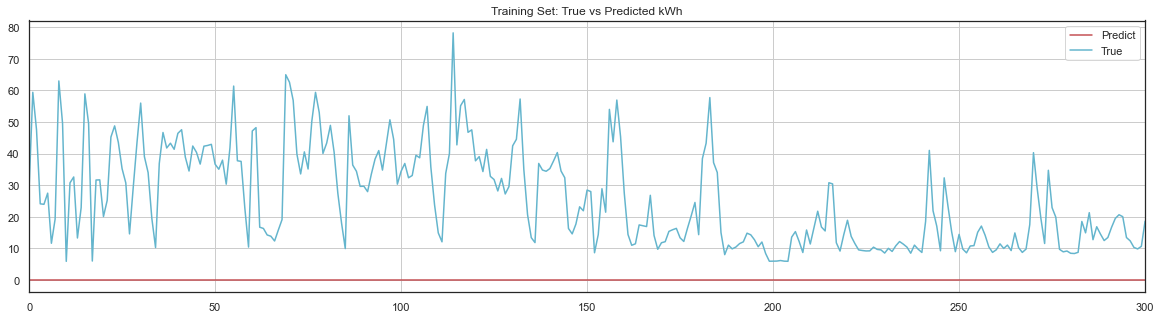

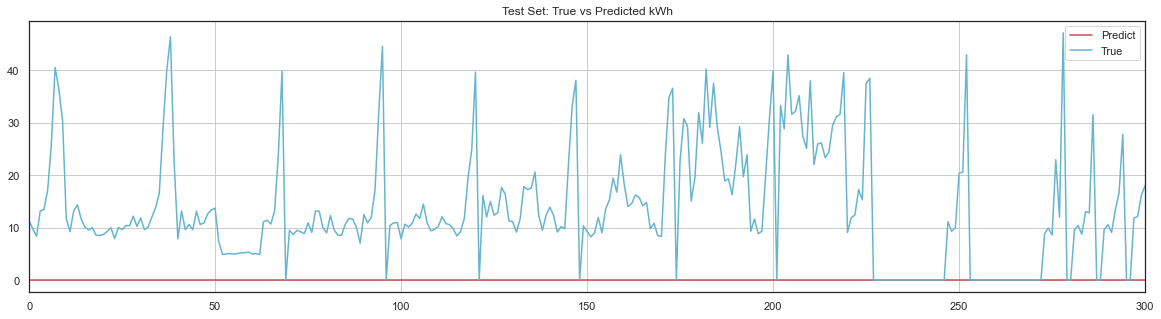

In [48]:
# plot model predictions 
plot_predictions(y_train, y_train_predict, y_test, y_test_predict)

In [52]:
# use root mean squared error as metric for comparison 
train_score = math.sqrt(mean_squared_error(y_train, y_train_predict))
print('Train Score: %.4f RMSE' % (train_score))

test_score = math.sqrt(mean_squared_error(y_test, y_test_predict))
print('Test Score: %.4f RMSE' % (test_score))

# navie_score = math.sqrt(mean_squared_error(...?, ...?))
# print('Naive baseline Score: %.4f RMSE' % (test_score))

Train Score: 25.8088 RMSE
Test Score: 17.5018 RMSE
